In [1]:
cd

C:\Users\Walter


In [2]:
cd Desktop/DataMiningTechniques/Assignment 1

C:\Users\Walter\Desktop\DataMiningTechniques\Assignment 1


In [3]:
cd patient_data/

C:\Users\Walter\Desktop\DataMiningTechniques\Assignment 1\patient_data


In [4]:
import pandas as pd
import pickle
from datetime import datetime
import re
from matplotlib import pyplot as plt
import numpy as np
#from sklearn import tree
#from sklearn.ensemble import RandomForestClassifier
import sklearn.ensemble as ske
#import graphviz 
#from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, scale
import math
#from sklearn.decomposition import PCA
#from sklearn.neighbors import KNeighborsRegressor

In [5]:
data_best_F_mse = pd.read_csv('Best_F_MSE', index_col=0, usecols=range(0,11))
data_best_F_corr = pd.read_csv('Best_F_Corr.csv',  index_col=0, usecols=range(1,12))

In [6]:
# Copy from internet

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#LSTM_opt = np.zeros([6,9])

#for n_features in [2]:
#    for lag in [3]:

n_features = 9
lag = 1

mses = []

#for i in range(12):  # Walter
#for i in range(12, 24): # Arran
for i in range(24, 34): # Viktor

    
    squared_error = []
        # load patient data
    try:
        data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
        continue

    print('\n --- Patient {:02d} ---'.format(i))

    #data_reindexed = data.loc[:,data_best_F_mse.loc[i].values]
    data_reindexed = data.loc[:,data_best_F_corr.loc[i].values]

    dataset = data_reindexed.iloc[:,:n_features]
    values = dataset.values

    seg = [0.7, 0.1, 0.2]
    t = len(dataset)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    #ys = values[splits[0]:,0]
    ys = values[splits[1]:,0]

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, lag, 1)

    # split into train and test sets
    values = reframed.values

    #for tt in range(t-splits[0]-1-math.floor((seg[2]*t))):
    for tt in range(t-splits[1]-lag):

        #train = values[:splits[0]+tt, :]
        train = values[:splits[1]+tt, :]
        #test = values[splits[0]+tt:splits[0]+math.floor((seg[1]*t)), :]
        test = values[splits[1]+tt:, :]
        #val = values[splits[0]+tt,:]
        val = values[splits[1]+tt,:]

        # split into input and outputs
        n_obs = lag * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]
        val_X, val_y = val[:n_obs], val[-n_features]

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], lag, n_features))
        test_X = test_X.reshape((test_X.shape[0], lag, n_features))
        val_X = val_X.reshape((1, lag, n_features))

        # design network
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam');
        # fit network
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False);

        # make a prediction
        yhat = model.predict(val_X)
        val_X = val_X.reshape((val_X.shape[0], lag*n_features))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, val_X[:, -(n_features-1):]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[0][0]
        #inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        #inv_y = concatenate((val_y, val_X[:, -(n_features-1):]), axis=1)
        #inv_y = scaler.inverse_transform(inv_y)
        inv_y = ys[tt+lag]
        #inv_y = inv_y[:,0]
        # calculate RMSE
        print('Predicted:', inv_yhat)
        print('Real:', inv_y)
        squared_error.append((inv_y - inv_yhat)**2)

    mse = np.mean(squared_error)
    print('\nMSE: {}'.format(mse))
    #print('Number of validations:', math.floor(t*seg[1]))
    mses.append(mse)
    
print('All MSES',mses)
        #LSTM_opt[lag, n_features] = np.mean(mses)
print('\n\nAvg. MSE (all patients): {} \n lag order: {} \n nr of features: {} '.format(np.mean(mses), lag, n_features))

Using TensorFlow backend.



 --- Patient 24 ---
Train on 43 samples, validate on 11 samples
Epoch 1/50
 - 1s - loss: 0.6448 - val_loss: 0.7144
Epoch 2/50
 - 0s - loss: 0.6354 - val_loss: 0.7043
Epoch 3/50
 - 0s - loss: 0.6262 - val_loss: 0.6941
Epoch 4/50
 - 0s - loss: 0.6173 - val_loss: 0.6839
Epoch 5/50
 - 0s - loss: 0.6084 - val_loss: 0.6738
Epoch 6/50
 - 0s - loss: 0.5995 - val_loss: 0.6637
Epoch 7/50
 - 0s - loss: 0.5906 - val_loss: 0.6535
Epoch 8/50
 - 0s - loss: 0.5817 - val_loss: 0.6434
Epoch 9/50
 - 0s - loss: 0.5727 - val_loss: 0.6332
Epoch 10/50
 - 0s - loss: 0.5638 - val_loss: 0.6230
Epoch 11/50
 - 0s - loss: 0.5549 - val_loss: 0.6128
Epoch 12/50
 - 0s - loss: 0.5459 - val_loss: 0.6025
Epoch 13/50
 - 0s - loss: 0.5369 - val_loss: 0.5922
Epoch 14/50
 - 0s - loss: 0.5278 - val_loss: 0.5819
Epoch 15/50
 - 0s - loss: 0.5187 - val_loss: 0.5715
Epoch 16/50
 - 0s - loss: 0.5096 - val_loss: 0.5610
Epoch 17/50
 - 0s - loss: 0.5004 - val_loss: 0.5505
Epoch 18/50
 - 0s - loss: 0.4911 - val_loss: 0.5399
Epoch 19

Epoch 3/50
 - 0s - loss: 0.5314 - val_loss: 0.5944
Epoch 4/50
 - 0s - loss: 0.5199 - val_loss: 0.5810
Epoch 5/50
 - 0s - loss: 0.5085 - val_loss: 0.5675
Epoch 6/50
 - 0s - loss: 0.4969 - val_loss: 0.5539
Epoch 7/50
 - 0s - loss: 0.4854 - val_loss: 0.5403
Epoch 8/50
 - 0s - loss: 0.4737 - val_loss: 0.5266
Epoch 9/50
 - 0s - loss: 0.4620 - val_loss: 0.5128
Epoch 10/50
 - 0s - loss: 0.4503 - val_loss: 0.4989
Epoch 11/50
 - 0s - loss: 0.4385 - val_loss: 0.4850
Epoch 12/50
 - 0s - loss: 0.4266 - val_loss: 0.4709
Epoch 13/50
 - 0s - loss: 0.4146 - val_loss: 0.4568
Epoch 14/50
 - 0s - loss: 0.4025 - val_loss: 0.4425
Epoch 15/50
 - 0s - loss: 0.3904 - val_loss: 0.4281
Epoch 16/50
 - 0s - loss: 0.3781 - val_loss: 0.4135
Epoch 17/50
 - 0s - loss: 0.3660 - val_loss: 0.3989
Epoch 18/50
 - 0s - loss: 0.3542 - val_loss: 0.3842
Epoch 19/50
 - 0s - loss: 0.3428 - val_loss: 0.3693
Epoch 20/50
 - 0s - loss: 0.3314 - val_loss: 0.3545
Epoch 21/50
 - 0s - loss: 0.3200 - val_loss: 0.3393
Epoch 22/50
 - 0s -

Epoch 7/50
 - 0s - loss: 0.5578 - val_loss: 0.7257
Epoch 8/50
 - 0s - loss: 0.5483 - val_loss: 0.7144
Epoch 9/50
 - 0s - loss: 0.5388 - val_loss: 0.7030
Epoch 10/50
 - 0s - loss: 0.5292 - val_loss: 0.6916
Epoch 11/50
 - 0s - loss: 0.5196 - val_loss: 0.6801
Epoch 12/50
 - 0s - loss: 0.5098 - val_loss: 0.6685
Epoch 13/50
 - 0s - loss: 0.5000 - val_loss: 0.6567
Epoch 14/50
 - 0s - loss: 0.4902 - val_loss: 0.6449
Epoch 15/50
 - 0s - loss: 0.4802 - val_loss: 0.6330
Epoch 16/50
 - 0s - loss: 0.4701 - val_loss: 0.6208
Epoch 17/50
 - 0s - loss: 0.4599 - val_loss: 0.6087
Epoch 18/50
 - 0s - loss: 0.4496 - val_loss: 0.5963
Epoch 19/50
 - 0s - loss: 0.4392 - val_loss: 0.5839
Epoch 20/50
 - 0s - loss: 0.4287 - val_loss: 0.5712
Epoch 21/50
 - 0s - loss: 0.4180 - val_loss: 0.5584
Epoch 22/50
 - 0s - loss: 0.4072 - val_loss: 0.5455
Epoch 23/50
 - 0s - loss: 0.3963 - val_loss: 0.5322
Epoch 24/50
 - 0s - loss: 0.3851 - val_loss: 0.5189
Epoch 25/50
 - 0s - loss: 0.3739 - val_loss: 0.5055
Epoch 26/50
 - 

Epoch 11/50
 - 0s - loss: 0.4690 - val_loss: 0.7387
Epoch 12/50
 - 0s - loss: 0.4562 - val_loss: 0.7217
Epoch 13/50
 - 0s - loss: 0.4433 - val_loss: 0.7047
Epoch 14/50
 - 0s - loss: 0.4304 - val_loss: 0.6874
Epoch 15/50
 - 0s - loss: 0.4173 - val_loss: 0.6701
Epoch 16/50
 - 0s - loss: 0.4042 - val_loss: 0.6526
Epoch 17/50
 - 0s - loss: 0.3909 - val_loss: 0.6350
Epoch 18/50
 - 0s - loss: 0.3776 - val_loss: 0.6172
Epoch 19/50
 - 0s - loss: 0.3641 - val_loss: 0.5993
Epoch 20/50
 - 0s - loss: 0.3510 - val_loss: 0.5812
Epoch 21/50
 - 0s - loss: 0.3384 - val_loss: 0.5630
Epoch 22/50
 - 0s - loss: 0.3258 - val_loss: 0.5447
Epoch 23/50
 - 0s - loss: 0.3131 - val_loss: 0.5263
Epoch 24/50
 - 0s - loss: 0.3004 - val_loss: 0.5078
Epoch 25/50
 - 0s - loss: 0.2881 - val_loss: 0.4892
Epoch 26/50
 - 0s - loss: 0.2763 - val_loss: 0.4704
Epoch 27/50
 - 0s - loss: 0.2645 - val_loss: 0.4516
Epoch 28/50
 - 0s - loss: 0.2530 - val_loss: 0.4327
Epoch 29/50
 - 0s - loss: 0.2416 - val_loss: 0.4137
Epoch 30/50


Epoch 14/50
 - 0s - loss: 0.2811 - val_loss: 0.2192
Epoch 15/50
 - 0s - loss: 0.2739 - val_loss: 0.2098
Epoch 16/50
 - 0s - loss: 0.2679 - val_loss: 0.2004
Epoch 17/50
 - 0s - loss: 0.2618 - val_loss: 0.1911
Epoch 18/50
 - 0s - loss: 0.2558 - val_loss: 0.1818
Epoch 19/50
 - 0s - loss: 0.2501 - val_loss: 0.1726
Epoch 20/50
 - 0s - loss: 0.2457 - val_loss: 0.1658
Epoch 21/50
 - 0s - loss: 0.2420 - val_loss: 0.1602
Epoch 22/50
 - 0s - loss: 0.2388 - val_loss: 0.1548
Epoch 23/50
 - 0s - loss: 0.2362 - val_loss: 0.1496
Epoch 24/50
 - 0s - loss: 0.2344 - val_loss: 0.1450
Epoch 25/50
 - 0s - loss: 0.2338 - val_loss: 0.1407
Epoch 26/50
 - 0s - loss: 0.2333 - val_loss: 0.1368
Epoch 27/50
 - 0s - loss: 0.2327 - val_loss: 0.1333
Epoch 28/50
 - 0s - loss: 0.2320 - val_loss: 0.1300
Epoch 29/50
 - 0s - loss: 0.2314 - val_loss: 0.1271
Epoch 30/50
 - 0s - loss: 0.2307 - val_loss: 0.1244
Epoch 31/50
 - 0s - loss: 0.2300 - val_loss: 0.1219
Epoch 32/50
 - 0s - loss: 0.2292 - val_loss: 0.1197
Epoch 33/50


Epoch 18/50
 - 0s - loss: 0.2172 - val_loss: 0.1285
Epoch 19/50
 - 0s - loss: 0.2163 - val_loss: 0.1216
Epoch 20/50
 - 0s - loss: 0.2154 - val_loss: 0.1154
Epoch 21/50
 - 0s - loss: 0.2145 - val_loss: 0.1097
Epoch 22/50
 - 0s - loss: 0.2135 - val_loss: 0.1046
Epoch 23/50
 - 0s - loss: 0.2128 - val_loss: 0.1002
Epoch 24/50
 - 0s - loss: 0.2124 - val_loss: 0.0964
Epoch 25/50
 - 0s - loss: 0.2119 - val_loss: 0.0931
Epoch 26/50
 - 0s - loss: 0.2114 - val_loss: 0.0903
Epoch 27/50
 - 0s - loss: 0.2109 - val_loss: 0.0880
Epoch 28/50
 - 0s - loss: 0.2104 - val_loss: 0.0861
Epoch 29/50
 - 0s - loss: 0.2098 - val_loss: 0.0845
Epoch 30/50
 - 0s - loss: 0.2092 - val_loss: 0.0833
Epoch 31/50
 - 0s - loss: 0.2085 - val_loss: 0.0824
Epoch 32/50
 - 0s - loss: 0.2079 - val_loss: 0.0818
Epoch 33/50
 - 0s - loss: 0.2072 - val_loss: 0.0814
Epoch 34/50
 - 0s - loss: 0.2065 - val_loss: 0.0813
Epoch 35/50
 - 0s - loss: 0.2058 - val_loss: 0.0814
Epoch 36/50
 - 0s - loss: 0.2051 - val_loss: 0.0817
Epoch 37/50


Epoch 21/50
 - 0s - loss: 0.3590 - val_loss: 0.3720
Epoch 22/50
 - 0s - loss: 0.3494 - val_loss: 0.3627
Epoch 23/50
 - 0s - loss: 0.3398 - val_loss: 0.3533
Epoch 24/50
 - 0s - loss: 0.3301 - val_loss: 0.3438
Epoch 25/50
 - 0s - loss: 0.3205 - val_loss: 0.3343
Epoch 26/50
 - 0s - loss: 0.3116 - val_loss: 0.3248
Epoch 27/50
 - 0s - loss: 0.3028 - val_loss: 0.3153
Epoch 28/50
 - 0s - loss: 0.2949 - val_loss: 0.3058
Epoch 29/50
 - 0s - loss: 0.2871 - val_loss: 0.2963
Epoch 30/50
 - 0s - loss: 0.2794 - val_loss: 0.2878
Epoch 31/50
 - 0s - loss: 0.2720 - val_loss: 0.2801
Epoch 32/50
 - 0s - loss: 0.2652 - val_loss: 0.2724
Epoch 33/50
 - 0s - loss: 0.2585 - val_loss: 0.2647
Epoch 34/50
 - 0s - loss: 0.2518 - val_loss: 0.2588
Epoch 35/50
 - 0s - loss: 0.2452 - val_loss: 0.2535
Epoch 36/50
 - 0s - loss: 0.2388 - val_loss: 0.2481
Epoch 37/50
 - 0s - loss: 0.2325 - val_loss: 0.2427
Epoch 38/50
 - 0s - loss: 0.2267 - val_loss: 0.2373
Epoch 39/50
 - 0s - loss: 0.2209 - val_loss: 0.2319
Epoch 40/50


Epoch 25/50
 - 0s - loss: 0.3419 - val_loss: 0.3357
Epoch 26/50
 - 0s - loss: 0.3336 - val_loss: 0.3290
Epoch 27/50
 - 0s - loss: 0.3255 - val_loss: 0.3223
Epoch 28/50
 - 0s - loss: 0.3176 - val_loss: 0.3156
Epoch 29/50
 - 0s - loss: 0.3102 - val_loss: 0.3088
Epoch 30/50
 - 0s - loss: 0.3030 - val_loss: 0.3020
Epoch 31/50
 - 0s - loss: 0.2961 - val_loss: 0.2953
Epoch 32/50
 - 0s - loss: 0.2891 - val_loss: 0.2885
Epoch 33/50
 - 0s - loss: 0.2824 - val_loss: 0.2816
Epoch 34/50
 - 0s - loss: 0.2758 - val_loss: 0.2748
Epoch 35/50
 - 0s - loss: 0.2698 - val_loss: 0.2686
Epoch 36/50
 - 0s - loss: 0.2639 - val_loss: 0.2638
Epoch 37/50
 - 0s - loss: 0.2581 - val_loss: 0.2606
Epoch 38/50
 - 0s - loss: 0.2527 - val_loss: 0.2584
Epoch 39/50
 - 0s - loss: 0.2473 - val_loss: 0.2561
Epoch 40/50
 - 0s - loss: 0.2419 - val_loss: 0.2539
Epoch 41/50
 - 0s - loss: 0.2365 - val_loss: 0.2516
Epoch 42/50
 - 0s - loss: 0.2311 - val_loss: 0.2493
Epoch 43/50
 - 0s - loss: 0.2257 - val_loss: 0.2470
Epoch 44/50


Epoch 28/50
 - 0s - loss: 0.3453 - val_loss: 0.3883
Epoch 29/50
 - 0s - loss: 0.3366 - val_loss: 0.3834
Epoch 30/50
 - 0s - loss: 0.3278 - val_loss: 0.3785
Epoch 31/50
 - 0s - loss: 0.3192 - val_loss: 0.3735
Epoch 32/50
 - 0s - loss: 0.3110 - val_loss: 0.3686
Epoch 33/50
 - 0s - loss: 0.3029 - val_loss: 0.3636
Epoch 34/50
 - 0s - loss: 0.2947 - val_loss: 0.3585
Epoch 35/50
 - 0s - loss: 0.2871 - val_loss: 0.3534
Epoch 36/50
 - 0s - loss: 0.2797 - val_loss: 0.3484
Epoch 37/50
 - 0s - loss: 0.2728 - val_loss: 0.3433
Epoch 38/50
 - 0s - loss: 0.2661 - val_loss: 0.3381
Epoch 39/50
 - 0s - loss: 0.2595 - val_loss: 0.3330
Epoch 40/50
 - 0s - loss: 0.2530 - val_loss: 0.3278
Epoch 41/50
 - 0s - loss: 0.2465 - val_loss: 0.3226
Epoch 42/50
 - 0s - loss: 0.2407 - val_loss: 0.3175
Epoch 43/50
 - 0s - loss: 0.2349 - val_loss: 0.3123
Epoch 44/50
 - 0s - loss: 0.2291 - val_loss: 0.3071
Epoch 45/50
 - 0s - loss: 0.2236 - val_loss: 0.3019
Epoch 46/50
 - 0s - loss: 0.2185 - val_loss: 0.2967
Epoch 47/50


Epoch 32/50
 - 0s - loss: 0.3032 - val_loss: 0.2620
Epoch 33/50
 - 0s - loss: 0.2947 - val_loss: 0.2651
Epoch 34/50
 - 0s - loss: 0.2869 - val_loss: 0.2681
Epoch 35/50
 - 0s - loss: 0.2792 - val_loss: 0.2711
Epoch 36/50
 - 0s - loss: 0.2715 - val_loss: 0.2741
Epoch 37/50
 - 0s - loss: 0.2643 - val_loss: 0.2771
Epoch 38/50
 - 0s - loss: 0.2574 - val_loss: 0.2800
Epoch 39/50
 - 0s - loss: 0.2504 - val_loss: 0.2830
Epoch 40/50
 - 0s - loss: 0.2435 - val_loss: 0.2859
Epoch 41/50
 - 0s - loss: 0.2370 - val_loss: 0.2887
Epoch 42/50
 - 0s - loss: 0.2305 - val_loss: 0.2916
Epoch 43/50
 - 0s - loss: 0.2242 - val_loss: 0.2945
Epoch 44/50
 - 0s - loss: 0.2179 - val_loss: 0.2973
Epoch 45/50
 - 0s - loss: 0.2120 - val_loss: 0.3002
Epoch 46/50
 - 0s - loss: 0.2062 - val_loss: 0.3030
Epoch 47/50
 - 0s - loss: 0.2003 - val_loss: 0.3058
Epoch 48/50
 - 0s - loss: 0.1945 - val_loss: 0.3086
Epoch 49/50
 - 0s - loss: 0.1893 - val_loss: 0.3113
Epoch 50/50
 - 0s - loss: 0.1846 - val_loss: 0.3141
Predicted: 7

 - 0s - loss: 0.1459 - val_loss: 0.1150
Epoch 35/50
 - 0s - loss: 0.1401 - val_loss: 0.1176
Epoch 36/50
 - 0s - loss: 0.1344 - val_loss: 0.1213
Epoch 37/50
 - 0s - loss: 0.1302 - val_loss: 0.1275
Epoch 38/50
 - 0s - loss: 0.1269 - val_loss: 0.1334
Epoch 39/50
 - 0s - loss: 0.1250 - val_loss: 0.1390
Epoch 40/50
 - 0s - loss: 0.1232 - val_loss: 0.1442
Epoch 41/50
 - 0s - loss: 0.1218 - val_loss: 0.1491
Epoch 42/50
 - 0s - loss: 0.1216 - val_loss: 0.1535
Epoch 43/50
 - 0s - loss: 0.1217 - val_loss: 0.1574
Epoch 44/50
 - 0s - loss: 0.1223 - val_loss: 0.1618
Epoch 45/50
 - 0s - loss: 0.1233 - val_loss: 0.1659
Epoch 46/50
 - 0s - loss: 0.1243 - val_loss: 0.1691
Epoch 47/50
 - 0s - loss: 0.1251 - val_loss: 0.1716
Epoch 48/50
 - 0s - loss: 0.1256 - val_loss: 0.1734
Epoch 49/50
 - 0s - loss: 0.1259 - val_loss: 0.1746
Epoch 50/50
 - 0s - loss: 0.1261 - val_loss: 0.1752
Predicted: 7.2381577
Real: 7.799999999999999
Train on 34 samples, validate on 7 samples
Epoch 1/50
 - 3s - loss: 0.5181 - val_lo

Epoch 38/50
 - 0s - loss: 0.1746 - val_loss: 0.1107
Epoch 39/50
 - 0s - loss: 0.1688 - val_loss: 0.1084
Epoch 40/50
 - 0s - loss: 0.1631 - val_loss: 0.1061
Epoch 41/50
 - 0s - loss: 0.1575 - val_loss: 0.1037
Epoch 42/50
 - 0s - loss: 0.1522 - val_loss: 0.1015
Epoch 43/50
 - 0s - loss: 0.1474 - val_loss: 0.0992
Epoch 44/50
 - 0s - loss: 0.1430 - val_loss: 0.0970
Epoch 45/50
 - 0s - loss: 0.1393 - val_loss: 0.0948
Epoch 46/50
 - 0s - loss: 0.1362 - val_loss: 0.0941
Epoch 47/50
 - 0s - loss: 0.1337 - val_loss: 0.0952
Epoch 48/50
 - 0s - loss: 0.1323 - val_loss: 0.0962
Epoch 49/50
 - 0s - loss: 0.1312 - val_loss: 0.0972
Epoch 50/50
 - 0s - loss: 0.1305 - val_loss: 0.0980
Predicted: 7.3054
Real: 6.599999999999998
Train on 37 samples, validate on 4 samples
Epoch 1/50
 - 4s - loss: 0.4630 - val_loss: 0.4175
Epoch 2/50
 - 0s - loss: 0.4555 - val_loss: 0.4071
Epoch 3/50
 - 0s - loss: 0.4453 - val_loss: 0.3967
Epoch 4/50
 - 0s - loss: 0.4352 - val_loss: 0.3863
Epoch 5/50
 - 0s - loss: 0.4253 - v

Epoch 42/50
 - 0s - loss: 0.1285 - val_loss: 0.0733
Epoch 43/50
 - 0s - loss: 0.1282 - val_loss: 0.0799
Epoch 44/50
 - 0s - loss: 0.1284 - val_loss: 0.0856
Epoch 45/50
 - 0s - loss: 0.1287 - val_loss: 0.0906
Epoch 46/50
 - 0s - loss: 0.1291 - val_loss: 0.0947
Epoch 47/50
 - 0s - loss: 0.1296 - val_loss: 0.0981
Epoch 48/50
 - 0s - loss: 0.1300 - val_loss: 0.1008
Epoch 49/50
 - 0s - loss: 0.1303 - val_loss: 0.1027
Epoch 50/50
 - 0s - loss: 0.1306 - val_loss: 0.1038
Predicted: 7.4066772
Real: 6.799999999999998
Train on 40 samples, validate on 1 samples
Epoch 1/50
 - 4s - loss: 0.4312 - val_loss: 0.4046
Epoch 2/50
 - 0s - loss: 0.4210 - val_loss: 0.3953
Epoch 3/50
 - 0s - loss: 0.4122 - val_loss: 0.3843
Epoch 4/50
 - 0s - loss: 0.4020 - val_loss: 0.3740
Epoch 5/50
 - 0s - loss: 0.3923 - val_loss: 0.3630
Epoch 6/50
 - 0s - loss: 0.3821 - val_loss: 0.3520
Epoch 7/50
 - 0s - loss: 0.3717 - val_loss: 0.3409
Epoch 8/50
 - 0s - loss: 0.3614 - val_loss: 0.3298
Epoch 9/50
 - 0s - loss: 0.3510 - va

Epoch 45/50
 - 0s - loss: 0.2790 - val_loss: 0.1009
Epoch 46/50
 - 0s - loss: 0.2742 - val_loss: 0.0990
Epoch 47/50
 - 0s - loss: 0.2698 - val_loss: 0.0993
Epoch 48/50
 - 0s - loss: 0.2654 - val_loss: 0.1015
Epoch 49/50
 - 0s - loss: 0.2622 - val_loss: 0.1046
Epoch 50/50
 - 0s - loss: 0.2597 - val_loss: 0.1075
Predicted: 7.0520806
Real: 6.799999999999999
Train on 32 samples, validate on 5 samples
Epoch 1/50
 - 4s - loss: 0.6123 - val_loss: 0.4534
Epoch 2/50
 - 0s - loss: 0.6032 - val_loss: 0.4441
Epoch 3/50
 - 0s - loss: 0.5941 - val_loss: 0.4348
Epoch 4/50
 - 0s - loss: 0.5850 - val_loss: 0.4254
Epoch 5/50
 - 0s - loss: 0.5758 - val_loss: 0.4161
Epoch 6/50
 - 0s - loss: 0.5667 - val_loss: 0.4067
Epoch 7/50
 - 0s - loss: 0.5575 - val_loss: 0.3973
Epoch 8/50
 - 0s - loss: 0.5483 - val_loss: 0.3879
Epoch 9/50
 - 0s - loss: 0.5390 - val_loss: 0.3785
Epoch 10/50
 - 0s - loss: 0.5298 - val_loss: 0.3689
Epoch 11/50
 - 0s - loss: 0.5205 - val_loss: 0.3594
Epoch 12/50
 - 0s - loss: 0.5111 - va

Epoch 48/50
 - 0s - loss: 0.2418 - val_loss: 0.0841
Epoch 49/50
 - 0s - loss: 0.2404 - val_loss: 0.0857
Epoch 50/50
 - 0s - loss: 0.2393 - val_loss: 0.0873
Predicted: 6.9473004
Real: 6.999999999999999
Train on 35 samples, validate on 2 samples
Epoch 1/50
 - 4s - loss: 0.6063 - val_loss: 0.3120
Epoch 2/50
 - 0s - loss: 0.5982 - val_loss: 0.3045
Epoch 3/50
 - 0s - loss: 0.5900 - val_loss: 0.2970
Epoch 4/50
 - 0s - loss: 0.5818 - val_loss: 0.2895
Epoch 5/50
 - 0s - loss: 0.5736 - val_loss: 0.2820
Epoch 6/50
 - 0s - loss: 0.5653 - val_loss: 0.2744
Epoch 7/50
 - 0s - loss: 0.5571 - val_loss: 0.2668
Epoch 8/50
 - 0s - loss: 0.5488 - val_loss: 0.2592
Epoch 9/50
 - 0s - loss: 0.5404 - val_loss: 0.2515
Epoch 10/50
 - 0s - loss: 0.5321 - val_loss: 0.2439
Epoch 11/50
 - 0s - loss: 0.5236 - val_loss: 0.2361
Epoch 12/50
 - 0s - loss: 0.5152 - val_loss: 0.2284
Epoch 13/50
 - 0s - loss: 0.5067 - val_loss: 0.2206
Epoch 14/50
 - 0s - loss: 0.4981 - val_loss: 0.2128
Epoch 15/50
 - 0s - loss: 0.4895 - va

 - 0s - loss: 0.1876 - val_loss: 0.1857
Predicted: 7.3029065
Real: 7.800000000000003
Train on 35 samples, validate on 7 samples
Epoch 1/50
 - 5s - loss: 0.6525 - val_loss: 0.6162
Epoch 2/50
 - 0s - loss: 0.6436 - val_loss: 0.6048
Epoch 3/50
 - 0s - loss: 0.6334 - val_loss: 0.5916
Epoch 4/50
 - 0s - loss: 0.6214 - val_loss: 0.5784
Epoch 5/50
 - 0s - loss: 0.6098 - val_loss: 0.5652
Epoch 6/50
 - 0s - loss: 0.5985 - val_loss: 0.5520
Epoch 7/50
 - 0s - loss: 0.5871 - val_loss: 0.5387
Epoch 8/50
 - 0s - loss: 0.5758 - val_loss: 0.5254
Epoch 9/50
 - 0s - loss: 0.5644 - val_loss: 0.5121
Epoch 10/50
 - 0s - loss: 0.5530 - val_loss: 0.4987
Epoch 11/50
 - 0s - loss: 0.5415 - val_loss: 0.4852
Epoch 12/50
 - 0s - loss: 0.5300 - val_loss: 0.4717
Epoch 13/50
 - 0s - loss: 0.5185 - val_loss: 0.4581
Epoch 14/50
 - 0s - loss: 0.5069 - val_loss: 0.4443
Epoch 15/50
 - 0s - loss: 0.4952 - val_loss: 0.4305
Epoch 16/50
 - 0s - loss: 0.4834 - val_loss: 0.4167
Epoch 17/50
 - 0s - loss: 0.4716 - val_loss: 0.40

Epoch 2/50
 - 0s - loss: 0.5961 - val_loss: 0.6050
Epoch 3/50
 - 0s - loss: 0.5852 - val_loss: 0.5926
Epoch 4/50
 - 0s - loss: 0.5743 - val_loss: 0.5802
Epoch 5/50
 - 0s - loss: 0.5634 - val_loss: 0.5677
Epoch 6/50
 - 0s - loss: 0.5525 - val_loss: 0.5553
Epoch 7/50
 - 0s - loss: 0.5416 - val_loss: 0.5428
Epoch 8/50
 - 0s - loss: 0.5306 - val_loss: 0.5303
Epoch 9/50
 - 0s - loss: 0.5197 - val_loss: 0.5178
Epoch 10/50
 - 0s - loss: 0.5087 - val_loss: 0.5052
Epoch 11/50
 - 0s - loss: 0.4977 - val_loss: 0.4925
Epoch 12/50
 - 0s - loss: 0.4866 - val_loss: 0.4798
Epoch 13/50
 - 0s - loss: 0.4755 - val_loss: 0.4671
Epoch 14/50
 - 0s - loss: 0.4644 - val_loss: 0.4543
Epoch 15/50
 - 0s - loss: 0.4532 - val_loss: 0.4414
Epoch 16/50
 - 0s - loss: 0.4419 - val_loss: 0.4284
Epoch 17/50
 - 0s - loss: 0.4310 - val_loss: 0.4153
Epoch 18/50
 - 0s - loss: 0.4201 - val_loss: 0.4022
Epoch 19/50
 - 0s - loss: 0.4091 - val_loss: 0.3890
Epoch 20/50
 - 0s - loss: 0.3981 - val_loss: 0.3757
Epoch 21/50
 - 0s - 

Epoch 6/50
 - 0s - loss: 0.5481 - val_loss: 0.5265
Epoch 7/50
 - 0s - loss: 0.5359 - val_loss: 0.5090
Epoch 8/50
 - 0s - loss: 0.5237 - val_loss: 0.4915
Epoch 9/50
 - 0s - loss: 0.5114 - val_loss: 0.4739
Epoch 10/50
 - 0s - loss: 0.4991 - val_loss: 0.4562
Epoch 11/50
 - 0s - loss: 0.4867 - val_loss: 0.4385
Epoch 12/50
 - 0s - loss: 0.4743 - val_loss: 0.4206
Epoch 13/50
 - 0s - loss: 0.4618 - val_loss: 0.4027
Epoch 14/50
 - 0s - loss: 0.4493 - val_loss: 0.3847
Epoch 15/50
 - 0s - loss: 0.4367 - val_loss: 0.3665
Epoch 16/50
 - 0s - loss: 0.4240 - val_loss: 0.3482
Epoch 17/50
 - 0s - loss: 0.4112 - val_loss: 0.3298
Epoch 18/50
 - 0s - loss: 0.3984 - val_loss: 0.3113
Epoch 19/50
 - 0s - loss: 0.3857 - val_loss: 0.2924
Epoch 20/50
 - 0s - loss: 0.3735 - val_loss: 0.2737
Epoch 21/50
 - 0s - loss: 0.3615 - val_loss: 0.2549
Epoch 22/50
 - 0s - loss: 0.3494 - val_loss: 0.2360
Epoch 23/50
 - 0s - loss: 0.3373 - val_loss: 0.2169
Epoch 24/50
 - 0s - loss: 0.3252 - val_loss: 0.1977
Epoch 25/50
 - 0

Epoch 9/50
 - 0s - loss: 0.4860 - val_loss: 0.5682
Epoch 10/50
 - 0s - loss: 0.4763 - val_loss: 0.5571
Epoch 11/50
 - 0s - loss: 0.4665 - val_loss: 0.5459
Epoch 12/50
 - 0s - loss: 0.4568 - val_loss: 0.5347
Epoch 13/50
 - 0s - loss: 0.4469 - val_loss: 0.5234
Epoch 14/50
 - 0s - loss: 0.4370 - val_loss: 0.5120
Epoch 15/50
 - 0s - loss: 0.4269 - val_loss: 0.5005
Epoch 16/50
 - 0s - loss: 0.4168 - val_loss: 0.4889
Epoch 17/50
 - 0s - loss: 0.4070 - val_loss: 0.4771
Epoch 18/50
 - 0s - loss: 0.3973 - val_loss: 0.4653
Epoch 19/50
 - 0s - loss: 0.3876 - val_loss: 0.4534
Epoch 20/50
 - 0s - loss: 0.3777 - val_loss: 0.4413
Epoch 21/50
 - 0s - loss: 0.3678 - val_loss: 0.4291
Epoch 22/50
 - 0s - loss: 0.3577 - val_loss: 0.4167
Epoch 23/50
 - 0s - loss: 0.3475 - val_loss: 0.4042
Epoch 24/50
 - 0s - loss: 0.3372 - val_loss: 0.3914
Epoch 25/50
 - 0s - loss: 0.3273 - val_loss: 0.3786
Epoch 26/50
 - 0s - loss: 0.3175 - val_loss: 0.3656
Epoch 27/50
 - 0s - loss: 0.3076 - val_loss: 0.3525
Epoch 28/50
 

Epoch 13/50
 - 0s - loss: 0.5111 - val_loss: 0.5900
Epoch 14/50
 - 0s - loss: 0.5017 - val_loss: 0.5795
Epoch 15/50
 - 0s - loss: 0.4924 - val_loss: 0.5689
Epoch 16/50
 - 0s - loss: 0.4830 - val_loss: 0.5583
Epoch 17/50
 - 0s - loss: 0.4735 - val_loss: 0.5476
Epoch 18/50
 - 0s - loss: 0.4640 - val_loss: 0.5368
Epoch 19/50
 - 0s - loss: 0.4544 - val_loss: 0.5260
Epoch 20/50
 - 0s - loss: 0.4447 - val_loss: 0.5150
Epoch 21/50
 - 0s - loss: 0.4350 - val_loss: 0.5040
Epoch 22/50
 - 0s - loss: 0.4252 - val_loss: 0.4928
Epoch 23/50
 - 0s - loss: 0.4153 - val_loss: 0.4815
Epoch 24/50
 - 0s - loss: 0.4053 - val_loss: 0.4701
Epoch 25/50
 - 0s - loss: 0.3951 - val_loss: 0.4586
Epoch 26/50
 - 0s - loss: 0.3849 - val_loss: 0.4469
Epoch 27/50
 - 0s - loss: 0.3752 - val_loss: 0.4352
Epoch 28/50
 - 0s - loss: 0.3654 - val_loss: 0.4233
Epoch 29/50
 - 0s - loss: 0.3555 - val_loss: 0.4113
Epoch 30/50
 - 0s - loss: 0.3454 - val_loss: 0.3991
Epoch 31/50
 - 0s - loss: 0.3353 - val_loss: 0.3867
Epoch 32/50


Epoch 17/50
 - 0s - loss: 0.4266 - val_loss: 0.4291
Epoch 18/50
 - 0s - loss: 0.4150 - val_loss: 0.4191
Epoch 19/50
 - 0s - loss: 0.4034 - val_loss: 0.4091
Epoch 20/50
 - 0s - loss: 0.3917 - val_loss: 0.3991
Epoch 21/50
 - 0s - loss: 0.3798 - val_loss: 0.3889
Epoch 22/50
 - 0s - loss: 0.3684 - val_loss: 0.3786
Epoch 23/50
 - 0s - loss: 0.3569 - val_loss: 0.3683
Epoch 24/50
 - 0s - loss: 0.3454 - val_loss: 0.3579
Epoch 25/50
 - 0s - loss: 0.3337 - val_loss: 0.3474
Epoch 26/50
 - 0s - loss: 0.3221 - val_loss: 0.3369
Epoch 27/50
 - 0s - loss: 0.3110 - val_loss: 0.3261
Epoch 28/50
 - 0s - loss: 0.2997 - val_loss: 0.3154
Epoch 29/50
 - 0s - loss: 0.2884 - val_loss: 0.3046
Epoch 30/50
 - 0s - loss: 0.2770 - val_loss: 0.2936
Epoch 31/50
 - 0s - loss: 0.2659 - val_loss: 0.2827
Epoch 32/50
 - 0s - loss: 0.2551 - val_loss: 0.2716
Epoch 33/50
 - 0s - loss: 0.2443 - val_loss: 0.2605
Epoch 34/50
 - 0s - loss: 0.2333 - val_loss: 0.2493
Epoch 35/50
 - 0s - loss: 0.2223 - val_loss: 0.2380
Epoch 36/50


Epoch 20/50
 - 0s - loss: 0.3094 - val_loss: 0.3960
Epoch 21/50
 - 0s - loss: 0.3028 - val_loss: 0.3914
Epoch 22/50
 - 0s - loss: 0.2962 - val_loss: 0.3867
Epoch 23/50
 - 0s - loss: 0.2895 - val_loss: 0.3821
Epoch 24/50
 - 0s - loss: 0.2827 - val_loss: 0.3774
Epoch 25/50
 - 0s - loss: 0.2759 - val_loss: 0.3727
Epoch 26/50
 - 0s - loss: 0.2691 - val_loss: 0.3680
Epoch 27/50
 - 0s - loss: 0.2621 - val_loss: 0.3632
Epoch 28/50
 - 0s - loss: 0.2552 - val_loss: 0.3584
Epoch 29/50
 - 0s - loss: 0.2492 - val_loss: 0.3536
Epoch 30/50
 - 0s - loss: 0.2437 - val_loss: 0.3489
Epoch 31/50
 - 0s - loss: 0.2381 - val_loss: 0.3441
Epoch 32/50
 - 0s - loss: 0.2326 - val_loss: 0.3393
Epoch 33/50
 - 0s - loss: 0.2270 - val_loss: 0.3345
Epoch 34/50
 - 0s - loss: 0.2214 - val_loss: 0.3297
Epoch 35/50
 - 0s - loss: 0.2157 - val_loss: 0.3248
Epoch 36/50
 - 0s - loss: 0.2108 - val_loss: 0.3200
Epoch 37/50
 - 0s - loss: 0.2059 - val_loss: 0.3152
Epoch 38/50
 - 0s - loss: 0.2010 - val_loss: 0.3104
Epoch 39/50


Epoch 24/50
 - 0s - loss: 0.2683 - val_loss: 0.3175
Epoch 25/50
 - 0s - loss: 0.2611 - val_loss: 0.3124
Epoch 26/50
 - 0s - loss: 0.2539 - val_loss: 0.3074
Epoch 27/50
 - 0s - loss: 0.2481 - val_loss: 0.3023
Epoch 28/50
 - 0s - loss: 0.2422 - val_loss: 0.2973
Epoch 29/50
 - 0s - loss: 0.2364 - val_loss: 0.2922
Epoch 30/50
 - 0s - loss: 0.2305 - val_loss: 0.2871
Epoch 31/50
 - 0s - loss: 0.2246 - val_loss: 0.2820
Epoch 32/50
 - 0s - loss: 0.2186 - val_loss: 0.2768
Epoch 33/50
 - 0s - loss: 0.2126 - val_loss: 0.2716
Epoch 34/50
 - 0s - loss: 0.2068 - val_loss: 0.2665
Epoch 35/50
 - 0s - loss: 0.2015 - val_loss: 0.2613
Epoch 36/50
 - 0s - loss: 0.1962 - val_loss: 0.2561
Epoch 37/50
 - 0s - loss: 0.1908 - val_loss: 0.2509
Epoch 38/50
 - 0s - loss: 0.1861 - val_loss: 0.2457
Epoch 39/50
 - 0s - loss: 0.1820 - val_loss: 0.2406
Epoch 40/50
 - 0s - loss: 0.1780 - val_loss: 0.2356
Epoch 41/50
 - 0s - loss: 0.1752 - val_loss: 0.2307
Epoch 42/50
 - 0s - loss: 0.1734 - val_loss: 0.2259
Epoch 43/50


Epoch 27/50
 - 0s - loss: 0.2825 - val_loss: 0.1996
Epoch 28/50
 - 0s - loss: 0.2739 - val_loss: 0.1910
Epoch 29/50
 - 0s - loss: 0.2652 - val_loss: 0.1823
Epoch 30/50
 - 0s - loss: 0.2565 - val_loss: 0.1733
Epoch 31/50
 - 0s - loss: 0.2475 - val_loss: 0.1644
Epoch 32/50
 - 0s - loss: 0.2385 - val_loss: 0.1554
Epoch 33/50
 - 0s - loss: 0.2301 - val_loss: 0.1464
Epoch 34/50
 - 0s - loss: 0.2229 - val_loss: 0.1373
Epoch 35/50
 - 0s - loss: 0.2157 - val_loss: 0.1309
Epoch 36/50
 - 0s - loss: 0.2102 - val_loss: 0.1293
Epoch 37/50
 - 0s - loss: 0.2056 - val_loss: 0.1279
Epoch 38/50
 - 0s - loss: 0.2028 - val_loss: 0.1265
Epoch 39/50
 - 0s - loss: 0.2010 - val_loss: 0.1253
Epoch 40/50
 - 0s - loss: 0.1996 - val_loss: 0.1243
Epoch 41/50
 - 0s - loss: 0.1996 - val_loss: 0.1244
Epoch 42/50
 - 0s - loss: 0.2002 - val_loss: 0.1279
Epoch 43/50
 - 0s - loss: 0.2006 - val_loss: 0.1310
Epoch 44/50
 - 0s - loss: 0.2009 - val_loss: 0.1339
Epoch 45/50
 - 0s - loss: 0.2011 - val_loss: 0.1364
Epoch 46/50


Epoch 31/50
 - 0s - loss: 0.2245 - val_loss: 0.0560
Epoch 32/50
 - 0s - loss: 0.2186 - val_loss: 0.0419
Epoch 33/50
 - 0s - loss: 0.2138 - val_loss: 0.0280
Epoch 34/50
 - 0s - loss: 0.2098 - val_loss: 0.0145
Epoch 35/50
 - 0s - loss: 0.2065 - val_loss: 0.0013
Epoch 36/50
 - 0s - loss: 0.2033 - val_loss: 0.0116
Epoch 37/50
 - 0s - loss: 0.2002 - val_loss: 0.0243
Epoch 38/50
 - 0s - loss: 0.1972 - val_loss: 0.0365
Epoch 39/50
 - 0s - loss: 0.1960 - val_loss: 0.0479
Epoch 40/50
 - 0s - loss: 0.1955 - val_loss: 0.0583
Epoch 41/50
 - 0s - loss: 0.1955 - val_loss: 0.0678
Epoch 42/50
 - 0s - loss: 0.1955 - val_loss: 0.0764
Epoch 43/50
 - 0s - loss: 0.1954 - val_loss: 0.0843
Epoch 44/50
 - 0s - loss: 0.1953 - val_loss: 0.0914
Epoch 45/50
 - 0s - loss: 0.1951 - val_loss: 0.0978
Epoch 46/50
 - 0s - loss: 0.1949 - val_loss: 0.1036
Epoch 47/50
 - 0s - loss: 0.1948 - val_loss: 0.1084
Epoch 48/50
 - 0s - loss: 0.1950 - val_loss: 0.1124
Epoch 49/50
 - 0s - loss: 0.1950 - val_loss: 0.1155
Epoch 50/50


Epoch 34/50
 - 0s - loss: 0.1329 - val_loss: 0.3460
Epoch 35/50
 - 0s - loss: 0.1332 - val_loss: 0.3399
Epoch 36/50
 - 0s - loss: 0.1336 - val_loss: 0.3347
Epoch 37/50
 - 0s - loss: 0.1343 - val_loss: 0.3306
Epoch 38/50
 - 0s - loss: 0.1351 - val_loss: 0.3273
Epoch 39/50
 - 0s - loss: 0.1356 - val_loss: 0.3249
Epoch 40/50
 - 0s - loss: 0.1359 - val_loss: 0.3233
Epoch 41/50
 - 0s - loss: 0.1360 - val_loss: 0.3224
Epoch 42/50
 - 0s - loss: 0.1359 - val_loss: 0.3221
Epoch 43/50
 - 0s - loss: 0.1357 - val_loss: 0.3224
Epoch 44/50
 - 0s - loss: 0.1353 - val_loss: 0.3232
Epoch 45/50
 - 0s - loss: 0.1348 - val_loss: 0.3245
Epoch 46/50
 - 0s - loss: 0.1341 - val_loss: 0.3263
Epoch 47/50
 - 0s - loss: 0.1334 - val_loss: 0.3284
Epoch 48/50
 - 0s - loss: 0.1325 - val_loss: 0.3309
Epoch 49/50
 - 0s - loss: 0.1318 - val_loss: 0.3335
Epoch 50/50
 - 0s - loss: 0.1312 - val_loss: 0.3363
Predicted: 5.7712803
Real: 8.2
Train on 24 samples, validate on 2 samples
Epoch 1/50
 - 7s - loss: 0.3997 - val_loss

In [779]:
reframed.shape

(34, 18)

In [750]:
t-splits[0]-3-math.floor((seg[2]*t))

1

In [759]:
LSTM_opt

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.4271607 , 0.18891746, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [737]:
scaler.inverse_transform(reframed)[splits[1]]

array([6.19999958, 6.99999988, 7.40000002, 7.80000017])

In [742]:
ys[7]

7.4

In [714]:
squared_error

[0.6689837942868457,
 0.2555792627717901,
 0.07335728951548921,
 0.07003516112512387,
 0.0017355813324685017]

In [ ]:
[0.6916442122747363,
 0.24850735018867542,
 0.01727503724833733,
 0.01491555360120375,
 3.094264911854621e-06]

In [240]:
val = values[splits[1]:,:]
val_X, val_y = val[:, :n_obs], val[:, -n_features]
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
yhat_val = model.predict(val_X)
val_X = val_X.reshape((val_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat_val = concatenate((yhat_val, val_X[:, -7:]), axis=1)
inv_yhat_val = scaler.inverse_transform(inv_yhat_val)
inv_yhat_val = inv_yhat_val[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y_val = concatenate((val_y, val_X[:, -7:]), axis=1)
inv_y_val = scaler.inverse_transform(inv_y_val)
inv_y_val = inv_y_val[:,0]

In [699]:
# Good KNN and RF model

KNN_Opt= np.zeros([11,11])
RF_Opt = np.zeros([11,11])


#for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:

#for n_features in [9,10]:
#    for lag in [1,2,3,4]:
        
# KNN Best features = 7, lag=1, method = mse, 7 neighbors
msesKNN = []
msesRF = []

n_features = 10
lag = 3
neighbors = 7

# RF Best features = 10, lag = 2, method = mse.

#n_features = 10

for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:

    try:
        mood_data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        if lag==1:
            data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)  
        elif lag==2:
            data = pd.read_csv(open('p{:02d}_k2.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        elif lag==3:
            data = pd.read_csv(open('p{:02d}_k3.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        elif lag==4:
            data = pd.read_csv(open('p{:02d}_k4.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
        continue

    print('\n --- Patient {:02d} ---'.format(i))

    # Get features with highest MSE    
    data_reindexed = data.loc[:,data_best_F_mse.loc[i].values]
    dataset = data_reindexed.iloc[:,:(n_features+1)]

    # Get features with highest correlation
    #data_reindexed = data.loc[:,data_best_F_corr.loc[i].values]
    #dataset = data_reindexed.iloc[:,:(n_features+1)]

    x_p = dataset.values
    y_p = data.loc[:,'next_mood'].values

    # Principal Components Analysis
    #pca = PCA(n_components=10)
    pca_data = scale(x_p, axis=0)
    #x_pca = pca.fit_transform(pca_data)

    x_pca = pca_data

    # Train, test, validation set
    seg = [0.7, 0.1, 0.2]
    t = len(data)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    train_x, train_y = x_pca[:splits[0]], y_p[:splits[0]]
    train2_x, train2_y = x_pca[:splits[1]], y_p[:splits[1]]   # includes validation data


    squared_errorKNN = []
    squared_errorRF = []


    for t in range(len(train2_x), len(y_p)):

    #for t in range(len(train_x), len(train2_x)):

        # KNN
        #knn = KNeighborsRegressor(n_neighbors =n_features-8)
        #knn.fit(train2_x[:t,:], train2_y[:t])
        #yhatKNN = knn.predict(train2_x[t,:].reshape(1,-1))

        # RandomForest
        #clf = ske.RandomForestRegressor(n_estimators=1, max_features=n_features)
        #clf = clf.fit(train2_x[:t,:], train2_y[:t])
        #yhatRF = clf.predict(train2_x[t,:].reshape(1,-1))

        # Final Test
        knn = KNeighborsRegressor(n_neighbors =neighbors)
        knn.fit(x_pca[:t,:], y_p[:t])
        yhatKNN = knn.predict(x_pca[t,:].reshape(1,-1))
        #
        clf = ske.RandomForestRegressor(n_estimators=2000, max_features=10)
        clf = clf.fit(x_pca[:t,:], y_p[:t])
        yhatRF = clf.predict(x_pca[t,:].reshape(1,-1))

        obs = y_p[t]
        #obs = train2_y[t]
        print('Predicted KNN: {:%s}, Predicted RFR: {:%s}, Observed: {:%s}' %(yhatKNN, yhatRF, obs))
        squared_errorKNN.append((obs - yhatKNN)**2)
        squared_errorRF.append((obs - yhatRF)**2)

    mseKNN = np.mean(squared_errorKNN)
    mseRF = np.mean(squared_errorRF)

    print('\nMSE KNN: {}'.format(mseKNN))
    msesKNN.append(mseKNN)

    print('\nMSE RF: {}'.format(mseRF))
    msesRF.append(mseRF)

print('\n\nAvg. MSE KNN (all patients): {}, lag: {}'.format(np.mean(msesKNN), lag))

#KNN_Opt[n_features,lag] = np.mean(msesKNN)

KNN_Final_MSE = np.mean(msesKNN)


print('\n\nAvg. MSE RF (all patients): {}, lag: {}'.format(np.mean(msesRF), lag))

#RF_Opt[n_features, lag] = np.mean(msesRF)

RF_Final_MSE = np.mean(msesRF)



 --- Patient 01 ---
Predicted KNN: {:[7.26428571]}, Predicted RFR: {:[7.2353]}, Observed: {:7.6}
Predicted KNN: {:[7.26428571]}, Predicted RFR: {:[7.3223]}, Observed: {:7.5}
Predicted KNN: {:[7.47857143]}, Predicted RFR: {:[7.25185]}, Observed: {:7.6}
Predicted KNN: {:[7.12142857]}, Predicted RFR: {:[7.311225]}, Observed: {:7.0}
Predicted KNN: {:[7.03571429]}, Predicted RFR: {:[7.02285]}, Observed: {:7.8}
Predicted KNN: {:[7.25]}, Predicted RFR: {:[7.35375]}, Observed: {:8.0}
Predicted KNN: {:[7.49285714]}, Predicted RFR: {:[7.512075]}, Observed: {:7.6}
Predicted KNN: {:[7.57857143]}, Predicted RFR: {:[7.2347]}, Observed: {:8.0}
Predicted KNN: {:[7.60714286]}, Predicted RFR: {:[7.493925]}, Observed: {:8.0}

MSE KNN: 0.18753401360544206

MSE RF: 0.25042008770829555

 --- Patient 02 ---
Predicted KNN: {:[6.86666667]}, Predicted RFR: {:[6.89535]}, Observed: {:6.5}
Predicted KNN: {:[6.72380952]}, Predicted RFR: {:[6.74044167]}, Observed: {:5.666666666666668}
Predicted KNN: {:[6.83333333]}

Predicted KNN: {:[7.1047619]}, Predicted RFR: {:[7.58913333]}, Observed: {:8.0}

MSE KNN: 0.7795731292517011

MSE RF: 1.1680709412778272

 --- Patient 14 ---
Predicted KNN: {:[6.7547619]}, Predicted RFR: {:[6.5081]}, Observed: {:7.5}
Predicted KNN: {:[6.79761905]}, Predicted RFR: {:[6.47494167]}, Observed: {:7.0}
Predicted KNN: {:[7.01904762]}, Predicted RFR: {:[6.61494167]}, Observed: {:7.0}
Predicted KNN: {:[6.94761905]}, Predicted RFR: {:[6.78661667]}, Observed: {:7.0}
Predicted KNN: {:[7.04761905]}, Predicted RFR: {:[7.23106667]}, Observed: {:7.333333333333332}
Predicted KNN: {:[7.23809524]}, Predicted RFR: {:[6.82810833]}, Observed: {:8.0}
Predicted KNN: {:[7.33333333]}, Predicted RFR: {:[7.0494]}, Observed: {:8.0}
Predicted KNN: {:[7.45238095]}, Predicted RFR: {:[7.24861667]}, Observed: {:7.666666666666668}

MSE KNN: 0.2189923469387755

MSE RF: 0.4894436178037851

 --- Patient 15 ---
Predicted KNN: {:[7.02857143]}, Predicted RFR: {:[7.0125]}, Observed: {:7.0}
Predicted KNN: {:[6.

Predicted KNN: {:[7.01428571]}, Predicted RFR: {:[7.201075]}, Observed: {:5.8}
Predicted KNN: {:[6.58571429]}, Predicted RFR: {:[6.5942]}, Observed: {:5.4}
Predicted KNN: {:[7.08571429]}, Predicted RFR: {:[7.1557]}, Observed: {:7.4}
Predicted KNN: {:[7.08571429]}, Predicted RFR: {:[7.53555]}, Observed: {:6.4}

MSE KNN: 0.47224125364431496

MSE RF: 0.622860737946441

 --- Patient 27 ---
Predicted KNN: {:[7.34285714]}, Predicted RFR: {:[7.59185]}, Observed: {:7.8}
Predicted KNN: {:[7.17142857]}, Predicted RFR: {:[7.47564167]}, Observed: {:7.0}
Predicted KNN: {:[7.45714286]}, Predicted RFR: {:[7.43150833]}, Observed: {:6.4}
Predicted KNN: {:[7.42142857]}, Predicted RFR: {:[7.84005833]}, Observed: {:6.6}
Predicted KNN: {:[7.39285714]}, Predicted RFR: {:[7.25283333]}, Observed: {:7.0}
Predicted KNN: {:[7.11428571]}, Predicted RFR: {:[7.52108333]}, Observed: {:7.8}
Predicted KNN: {:[7.51428571]}, Predicted RFR: {:[7.153725]}, Observed: {:6.8}
Predicted KNN: {:[7.13333333]}, Predicted RFR: {:

In [688]:
KNN_Final_MSE

0.4577014932990383

In [700]:
# Calculate Confidence Interval

std_KNN = np.std(msesKNN, ddof=1)
std_RF = np.std(msesRF, ddof=1)
 
       
upper_bound_KNN = KNN_Final_MSE + (2.06*std_KNN/np.sqrt(27))
lower_bound_KNN = KNN_Final_MSE - (2.06*std_KNN/np.sqrt(27))

upper_bound_RF = RF_Final_MSE + (2.06*std_RF/np.sqrt(27))
lower_bound_RF = RF_Final_MSE - (2.06*std_RF/np.sqrt(27))
    
print('KNN: Mean, Std, Lower Bound, Upperbound \n', KNN_Final_MSE, std_KNN, lower_bound_KNN, upper_bound_KNN)
print('RF: Mean, Std, Lower Bound, Upperbound \n', RF_Final_MSE, std_RF, lower_bound_RF, upper_bound_RF) 

KNN: Mean, Std, Lower Bound, Upperbound 
 0.44000260764801974 0.533799050900829 0.22837947664623096 0.6516257386498086
RF: Mean, Std, Lower Bound, Upperbound 
 0.4699835707951887 0.4909000096975989 0.2753676439109077 0.6645994976794698


In [704]:
# Calculate BenchMark predict average over array

mse_BenchMark = []

for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:
    
    try:
        mood_data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
            continue

    print('\n --- Patient {:02d} ---'.format(i))

    # Get features with highest MSE    
    x_p = mood_data.loc[:, 'mood'].values
    y_p = mood_data.loc[:,'next_mood'].values

    seg = [0.7, 0.1, 0.2]
    t = len(mood_data)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    squared_er = []
    for step in range(splits[1], t):
        
        x, y = x_p[:step], y_p[step-1]

        squared_er.append((np.mean(x)-y)**2)

    mse = np.mean(squared_er)
    
    print(mse)

    mse_BenchMark.append(mse)

print('BenchMark Total MSE:', np.mean(mse_BenchMark))

std = np.std(mse_BenchMark, ddof=1)
 
       
upper_bound = np.mean(mse_BenchMark) + (2.06*std/np.sqrt(27))
lower_bound = np.mean(mse_BenchMark) - (2.06*std/np.sqrt(27))


    
print('BenchMark: Mean, Std, Lower Bound, Upperbound \n', np.mean(mse_BenchMark), std, lower_bound, upper_bound)
        


 --- Patient 01 ---
0.4400139097276851

 --- Patient 02 ---
1.0135778559663864

 --- Patient 03 ---
0.1451684016769604

 --- Patient 05 ---
0.2566042489436586

 --- Patient 06 ---
0.24501300262047307

 --- Patient 07 ---
1.6119053541589046

 --- Patient 08 ---
0.4830657333528737

 --- Patient 09 ---
0.3795026623701941

 --- Patient 12 ---
0.45337839419630194

 --- Patient 13 ---
0.9016303105702779

 --- Patient 14 ---
0.4055448103648431

 --- Patient 15 ---
0.1408849155953342

 --- Patient 16 ---
0.6268072071044354

 --- Patient 17 ---
0.19001798710418624

 --- Patient 19 ---
0.3354898264333701

 --- Patient 20 ---
0.03759496246247296

 --- Patient 23 ---
0.2525501163808225

 --- Patient 24 ---
0.24917476502184588

 --- Patient 25 ---
0.08353074977358552

 --- Patient 26 ---
0.5301852602083613

 --- Patient 27 ---
0.3324307071662039

 --- Patient 28 ---
0.3558497565995352

 --- Patient 29 ---
0.13751182994907885

 --- Patient 30 ---
0.04409044065844146

 --- Patient 31 ---
0.021587113

In [505]:
# RandomForestRegressor for Feature Importances

StandardScaler()       
best_F_mse = []


for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:
#for i in [1,2]:

    if i < 10:
        data = pd.read_csv('p0%s.csv'%i)
        data = data[:math.floor(0.8*len(data))]
        #locals()["x_p0"+str(i)] = data.iloc[:-1,2:]
        #locals()["y_p0"+str(i)] = data.iloc[1:,1]
        
    else:
        data = pd.read_csv('p%s.csv'%i)
        data = data[:math.floor(0.8*len(data))]
        
    
    x_labels = np.array(data.columns[3:])
    x_p = data.iloc[:,3:]
    y_p = data.iloc[:,1]
    clf = ske.RandomForestRegressor(n_estimators=2000, max_features=len(x_p.iloc[0,:]))
    clf = clf.fit(x_p, y_p)
    
    fet_ind = np.argsort(clf.feature_importances_)[::-1]
    fet_imp = clf.feature_importances_[fet_ind]
    labels = x_labels[fet_ind]
    best_F_mse.append(labels[:9])
    


In [506]:
data_best_F_mse = pd.DataFrame(data=best_F_mse, columns=range(1,10),index=[1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33])

In [507]:
value = np.array(['mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood'])
data_best_F_mse.insert(0, 0, value)

In [509]:
data_best_F_mse.to_csv('Best_F_MSE')

In [593]:
data_best_F_corr = pd.read_csv('Best_F_Corr.csv',  index_col=0, usecols=range(1,12))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

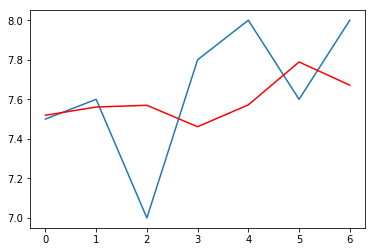

In [83]:
# Arima model, possible benchmark?
trainData = data1[0][:39].values
testData = data1[0][39:46].values

history = [x for x in trainData]
predictions = list()

for t in range(len(testData)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = testData[t]
    history.append(obs)
    
plt.plot(testData)
plt.plot(predictions, color='red')
plt.show()

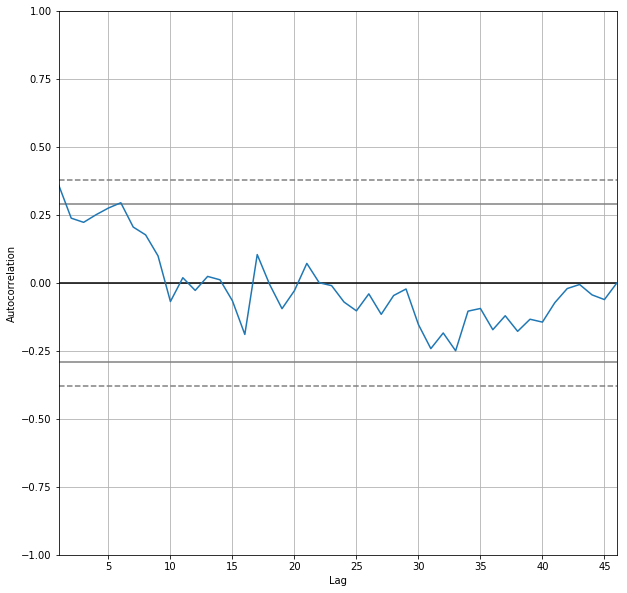

In [62]:
# Autocorrelation
moodp1 = data3[0][:46]
plt.figure(figsize=[10,10])
autocorrelation_plot(moodp1)